In [27]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [28]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, PyCall
import PyPlot; const plt = PyPlot ;

In [29]:
pcp_source_params = CSV.read("../pcpsaft_params/training_data.csv", DataFrame, header=1) ;

In [30]:
header_names = ["epoch", "species", "Mw", "m", "σ", "λ_a", "λ_r", "ϵ"]
raw_params = CSV.File("../params_log_all_alkanes_sat_v_500_epochs.csv"; header=header_names) |> DataFrame

Row,epoch,species,Mw,m,σ,λ_a,λ_r,ϵ
,Int64,String31,Float64,Float64,Float64,Float64,Float64,Float64
1,1,"2,5-dimethylhexane",114.141,2.55343,3.53049,6.0,11.6947,253.054
2,1,2-methylheptane,114.141,2.55329,3.53034,6.0,11.6962,253.039
3,1,3-methyldecane,156.188,2.55256,3.52958,6.0,11.7038,252.964
4,1,hexadecane,226.266,2.55365,3.53072,6.0,11.6924,253.077
5,1,"3,3-dimethylhexane",114.141,2.55328,3.53033,6.0,11.6963,253.039
6,1,3-methyltridecane,198.235,2.55311,3.53015,6.0,11.6981,253.021
7,1,2-methylbutane,72.094,2.55206,3.52905,6.0,11.7091,252.91
8,1,nonane,128.157,2.55304,3.53008,6.0,11.6988,253.014
9,1,heptacosane,380.438,2.55371,3.53078,6.0,11.6918,253.084


In [31]:
unique_values = unique(raw_params[!, :species])
num_rows = length(unique_values)

processed_data = DataFrame(
    species = fill(missing, num_rows),
    isomeric_SMILES = fill("", num_rows),
    Mw = fill(0.0, num_rows),
    m = fill([0.0], num_rows), 
    σ = fill([0.0], num_rows),
    λ_a = fill([0.0], num_rows),
    λ_r = fill([0.0], num_rows),
    ϵ = fill([0.0], num_rows)
) ;

processed_data.species = unique_values ;

In [40]:
for i in unique_values
    raw_params_spec = filter(row -> isequal(row.species, i), raw_params)
    num_epochs = nrow(raw_params_spec)

    row_number_processed = findall(isequal(i), processed_data.species)
    row_number_source = findall(isequal(i), pcp_source_params.species)

    processed_data[row_number_processed,:isomeric_SMILES] = pcp_source_params[row_number_source,:isomeric_SMILES]
    processed_data[row_number_processed,:Mw] = [raw_params_spec[1,:Mw]]
    processed_data[row_number_processed,:m] = [[raw_params_spec[i,:m] for i = 1:num_epochs]]
    processed_data[row_number_processed,:σ] = [[raw_params_spec[i,:σ] for i = 1:num_epochs]]
    processed_data[row_number_processed,:ϵ] = [[raw_params_spec[i,:ϵ] for i = 1:num_epochs]]
    processed_data[row_number_processed,:λ_a] = [[raw_params_spec[i,:λ_a] for i = 1:num_epochs]]
    processed_data[row_number_processed,:λ_r] = [[raw_params_spec[i,:λ_r] for i = 1:num_epochs]]
    
end

processed_data = sort(processed_data, :Mw) ;

In [43]:
contains_only_c(name) = all(letter -> lowercase(letter) == 'c', name) ;
processed_data_lin_alkanes = filter(row -> contains_only_c(row.isomeric_SMILES), processed_data) 
processed_data_lin_alkanes = sort(processed_data_lin_alkanes, :Mw) ;

# raw_params_spec = filter(row -> contains(row.species, i), raw_params)

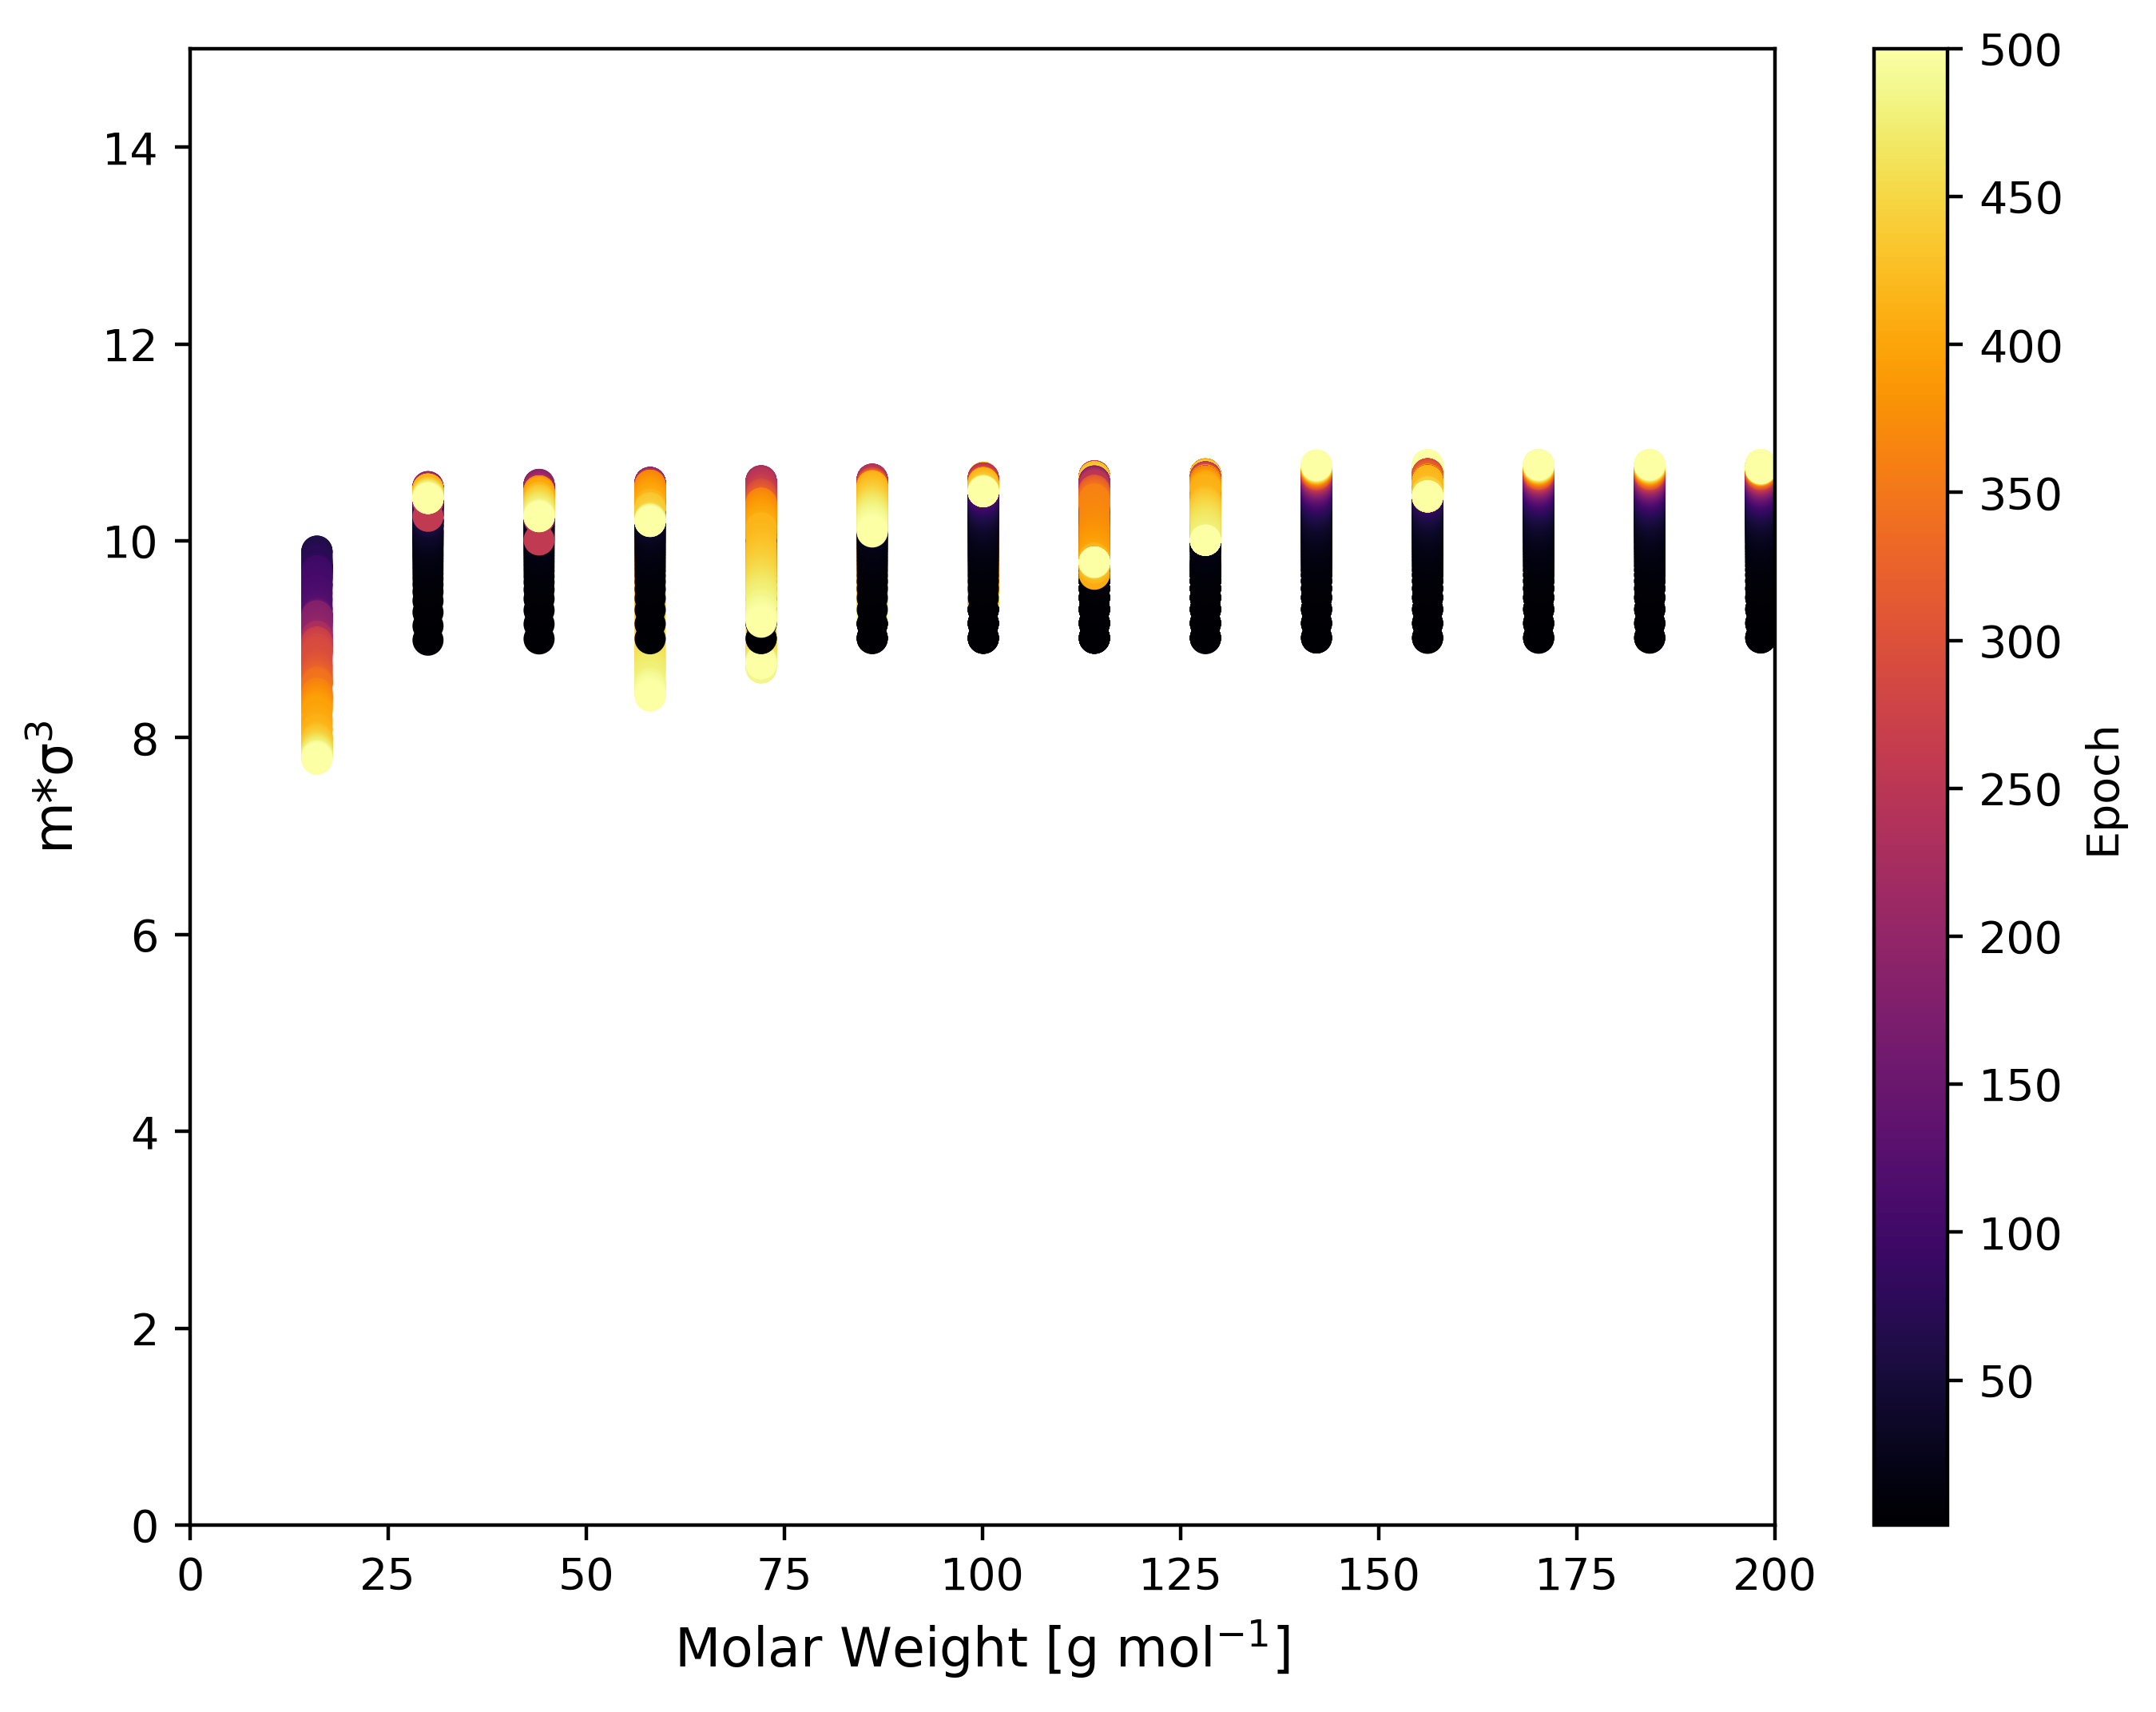

In [50]:
num_epochs = length(processed_data[1,:m])

plt.figure(figsize=(8, 6), dpi=400)

color_mapping = collect(range(1,num_epochs))

for j = 1:nrow(processed_data)

    mol_weight = fill(processed_data[j,:Mw], num_epochs)
    ms = processed_data[j,:m]
    σs = processed_data[j,:σ]

    m_sigmacubed = [ms[i]*σs[i] for i in 1:num_epochs]

    plt.scatter(mol_weight, m_sigmacubed, c=color_mapping, cmap="inferno")
end

plt.colorbar(ticks = 0:50:num_epochs,label = "Epoch")

plt.xlabel("Molar Weight [g mol\$^{-1}\$]",fontsize=12)
plt.ylabel("m*σ\$^3\$",fontsize=12)
plt.ylim([0,15])
plt.xlim([0,200]) ;

# for i = 1:nrows_data
#     plt.semilogx(1 ./filtered_training_data[i,:sat_volumes_vap_m3_per_mol],filtered_training_data[i,:sat_temperatures_K],color = [colour_grad_1[i] 0 colour_grad_2[i]])
# end

# plt.savefig("all_compound_phase_envelopes.png",dpi=400)